In [1]:
!pip install pandas-profiling
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas_profiling

In [2]:
# Upload Mobility report dataset for 2021
df = pd.read_csv('datasets/2021_GB_Region_Mobility_Report.csv')

# Upload Mobility report dataset for 2021
df0 = pd.read_csv('datasets/2020_GB_Region_Mobility_Report.csv')

# Concat datasets
df = pd.concat([df0, df])
df.drop(['country_region_code', 'country_region'], axis=1)

# Upload restrictions dataset

df1 = pd.read_csv('datasets/restrictions_daily.csv')

# Merge datatsets
data = pd.merge(df, df1, how="inner", on=["date"])

# Obtain report of the dataset
prof = pandas_profiling.ProfileReport(data)
prof.to_file(output_file='output.html')

data.to_csv('datasets/london_mobility_restrictions.csv')

KeyboardInterrupt: 

In [14]:
from matplotlib.dates import DateFormatter

df2 = pd.read_excel('tfl-journeys-type.xlsx', sheet_name=1)

df2

'''Problem: this dataset has the MONTHLY JOURNEYS'''

# df = df.loc[df['Period beginning'] > '2020-01-01']
# plt.figure(figsize=(20, 10))
# # plt.plot(df['Period beginning'], df['Bus journeys (m)'], '.-r', label='Bus')
# # plt.plot(df['Period beginning'], df['Underground journeys (m)'], '.-y', label='Underground')
# # plt.plot(df['Period beginning'], df['DLR Journeys (m)'], '.-g', label='DLR')
# # plt.plot(df['Period beginning'], df['Tram Journeys (m)'], '.-b', label='Tram')
# legend= ['Bus', 'Underground','DLR', 'Tram' ]
# plt.stackplot(df['Period beginning'],df['Bus journeys (m)'], df['Underground journeys (m)'],df['DLR Journeys (m)'], df['Tram Journeys (m)'] , labels=legend )
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.title('Number of journeys on the public transport network by type of transport (in millions)', fontsize=20)
# plt.show()

,Period and Financial year,Reporting Period,Days in period,Period beginning,Period ending,Bus journeys (m),Underground journeys (m),DLR Journeys (m),Tram Journeys (m),Overground Journeys (m),Emirates Airline Journeys (m),TfL Rail Journeys (m)
0,01_10/11,1,31,2010-04-01,2010-05-01,189.114661,90.545391,6.291000,2.287785,NaN,NaN,NaN
1,02_10/11,2,28,2010-05-02,2010-05-29,181.604792,84.517504,5.813000,2.154791,NaN,NaN,NaN
2,03_10/11,3,28,2010-05-30,2010-06-26,175.883173,84.286014,5.752000,2.129122,NaN,NaN,NaN
3,04_10/11,4,28,2010-06-27,2010-07-24,183.428052,86.479612,6.064480,2.141941,NaN,NaN,NaN
4,05_10/11,5,28,2010-07-25,2010-08-21,160.422767,82.895287,5.767624,2.008482,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
138,09_19/20,9,28,2020-11-15,2020-12-12,88.994047,32.123281,4.008240,1.130222,6.704696,0.020520,2.076430
139,10_19/20,10,28,2020-12-13,2021-01-09,57.480443,18.829917,2.741322,0.738954,3.571976,0.029085,1.218441
140,11_19/20,11,28,2021-01-10,2021-02-06,51.707250,16.750937,2.662126,0.668001,3.519877,0.018906,1.154206
141,12_19/20,12,28,2021-02-07,2021-03-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
from bokeh.models import LogColorMapper
from bokeh.palettes import RdYlBu11 as palette
from bokeh.palettes import Viridis6
from bokeh.plotting import figure
from bokeh.models import (
    GeoJSONDataSource,
    HoverTool,
    LinearColorMapper
)
from bokeh.io import show, output_notebook, output_file
import json



with open('datasets/london_boroughs.geojson') as f:
    london_source = GeoJSONDataSource(geojson=f.read())

with open('datasets/CycleRoutes.geojson') as f:
    cycle_source = GeoJSONDataSource(geojson=f.read())

    
with open('datasets/cycle_hire_locations.geojson') as f:
    docking_source = GeoJSONDataSource(geojson=f.read())


color_mapper = LinearColorMapper(palette=Viridis6)

TOOLS = "pan,wheel_zoom,box_zoom,reset,hover,save"

p = figure(title="Cycle Routes", tools=TOOLS, x_axis_location=None,
           y_axis_location=None, width=600, height=400)
p.grid.grid_line_color = None


# Plot map of Greater London
p.patches('xs', 'ys', source=london_source,
          fill_color={'field': '@name', 'transform': color_mapper},
          fill_alpha=1.0, line_color="black", line_width=0.5)

# Plot cycle routes on top
p.multi_line('xs', 'ys', source=cycle_source, line_alpha=1, line_color='red',
             line_width=0.7)
p.circle('longitude', 'latitude', source=docking_source, )

        


hover = p.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = [("Borough", "@name")]

output_file("Cycle_Routes.html", title="Cycle Routes")

show(p)

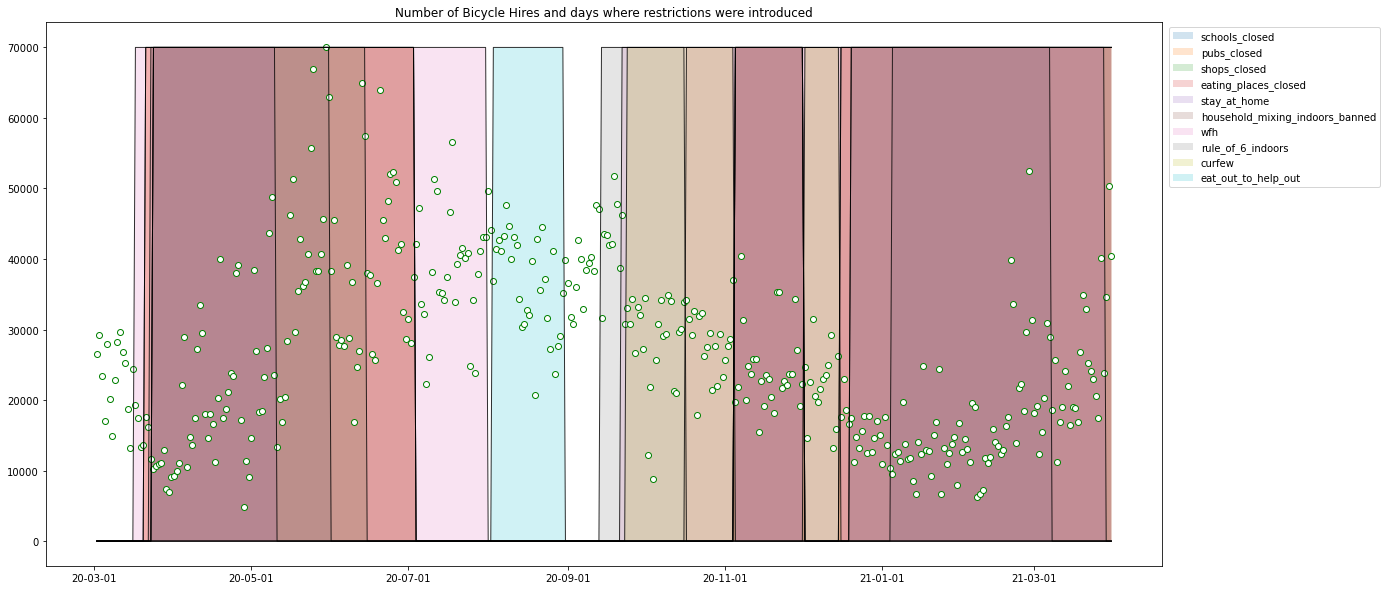

In [3]:
import pandas as pd
from matplotlib.dates import DateFormatter
cycle_hires = pd.read_excel('datasets/tfl-daily-cycle-hires.xlsx', sheet_name='Data')



# remove data previous to 2020
cycle_hires = cycle_hires.loc[cycle_hires['Day']>'2020-03-01']
df1 = df1.loc[df1['date']>'2020-03-01']
# remove data after 2021-04-01
df1 = df1.loc[df1['date']<'2021-04-01']
cycle_hires = cycle_hires.loc[cycle_hires['Day']<'2021-04-01']

fig, ax = plt.subplots(figsize=(20,10))

ax.plot(cycle_hires['Day'], cycle_hires['Number of Bicycle Hires'], 'wo',  mec='green', mew=1)




for col in df1.columns[1:]:
    ax.plot(cycle_hires['Day'], df1[col]*70000, alpha=0.8,linestyle='-', linewidth=1, color='black')
    ax.fill_between(cycle_hires['Day'], df1[col]*70000, label=col, alpha=0.2,)
    
#     for value in df1[col]:
#         if value == 1:
#             ax.plot(cycle_hires['Day'], 70000)
#          ax.fill_between(cycle_hires['Day'], df1[col], label=col, alpha=0.3)
    
ax.xaxis.set_major_formatter(DateFormatter("%y-%m-%d"))
plt.legend(bbox_to_anchor=(1.2, 1), loc='upper right')
plt.title('Number of Bicycle Hires and days where restrictions were introduced')
plt.show()

In [6]:
!pip install convertbng
import convertbng
from convertbng.util import convert_bng, convert_lonlat

In [ ]:
bus_stops = pd.read_csv('datasets/bus-stops-10-06-15.csv')

res_list_en = convert_lonlat(bus_stops.Location_Easting, bus_stops.Location_Northing)


In [ ]:
from bokeh.models import ColumnDataSource, FactorRange, Legend
from bokeh.palettes import viridis
from bokeh.plotting import figure
from bokeh.transform import factor_cmap
from bokeh.models import Legend
from bokeh.io import show, output_notebook


source = df1
factors = [str(i) for i in list(range(10))]
p = figure(x_range = FactorRange(factors=factors), plot_height=400, plot_width=1000, title="SF normalized crimes by hour",
           toolbar_location=None, tools="")
bar ={}
legend_items = []


for indx, i in enumerate(focuscrimes):
    bar[i] = p.vbar(x='Hour', top=i, source=source, width=0.9, color=viridis(14)[indx],
                    alpha=0.8, muted_color=viridis(14)[indx], muted_alpha=0.2)
    legend_items.append((i, [bar[i]]))

legend = Legend(items=legend_items)
p.add_layout(legend,'left')
p.legend.click_policy = 'mute'
output_notebook()
show(p)


In [54]:
import numpy as np
import pandas as pd
import datetime
from bokeh.io import show
from bokeh.layouts import column
from bokeh.models import ColumnDataSource, RangeTool, Legend, Label
from bokeh.plotting import figure
from bokeh.palettes import Viridis6
from bokeh.io import show, output_notebook, output_file



# Upload Mobility report dataset for 2021
df = pd.read_csv('datasets/2021_GB_Region_Mobility_Report.csv')

# Upload Mobility report dataset for 2021
df0 = pd.read_csv('datasets/2020_GB_Region_Mobility_Report.csv')

# Concat datasets
df = pd.concat([df0, df])
df.drop(['country_region_code', 'country_region'], axis=1)
print(df.head())

# Extract greater london area
df = df.loc[df.sub_region_1 == 'Greater London']
df.sub_region_2 = df.sub_region_2.fillna(0)
df = df.loc[df.sub_region_2 == 0]
df.date = pd.to_datetime(df.date)


# Bokeh
p = figure(plot_height=300, plot_width=800, tools=["xpan"], toolbar_location=None, title="Mobility in Greater London",
           x_axis_type="datetime", x_range=(min(df.date), max(df.date)))

line ={}
legend_items = []


for index, baseline_col in enumerate(list(df.columns.values)[-6:]):
    
    line[baseline_col] = p.line(df.date, df[baseline_col], color=Viridis6[index],
                    alpha=1, muted_color=Viridis6[index], muted_alpha=0.1, line_width=2)
    
    # Add legend and make it readable
    legend_items.append((baseline_col.replace('_', ' ')[:-28], [line[baseline_col]]))


legend = Legend(items=legend_items)
p.add_layout(legend,'left')
p.legend.click_policy = 'mute'


# Add baseline line
p.line(df.date, 0, color='black', line_width=0.5, line_dash='dashed')


p.yaxis.axis_label = 'Change from baseline'

select = figure(title="Drag the middle and edges of the selection box to change the date range above",
                plot_height=100, plot_width=800, y_range=p.y_range,
                x_axis_type="datetime", y_axis_type=None,
                tools="", toolbar_location=None)

range_tool = RangeTool(x_range=p.x_range)
range_tool.overlay.fill_color = "navy"
range_tool.overlay.fill_alpha = 0.2



for baseline_col in list(df.columns.values)[-6:]:
    select.line(df.date, df[baseline_col])
select.ygrid.grid_line_color = None
select.add_tools(range_tool)
select.toolbar.active_multi = range_tool

show(column(p, select))


output_file("ChangeBaseline.html")


  country_region_code  country_region sub_region_1 sub_region_2  metro_area  \
0                  GB  United Kingdom          NaN          NaN         NaN   
1                  GB  United Kingdom          NaN          NaN         NaN   
2                  GB  United Kingdom          NaN          NaN         NaN   
3                  GB  United Kingdom          NaN          NaN         NaN   
4                  GB  United Kingdom          NaN          NaN         NaN   

  iso_3166_2_code  census_fips_code                     place_id        date  \
0             NaN               NaN  ChIJqZHHQhE7WgIReiWIMkOg-MQ  2020-02-15   
1             NaN               NaN  ChIJqZHHQhE7WgIReiWIMkOg-MQ  2020-02-16   
2             NaN               NaN  ChIJqZHHQhE7WgIReiWIMkOg-MQ  2020-02-17   
3             NaN               NaN  ChIJqZHHQhE7WgIReiWIMkOg-MQ  2020-02-18   
4             NaN               NaN  ChIJqZHHQhE7WgIReiWIMkOg-MQ  2020-02-19   

   retail_and_recreation_percent_change_from

In [57]:
import plotly.express as px
import pandas as pd


df = pd.DataFrame([
    dict(Task='schools_closed_0', Start='2020-03-23', Finish='2020-05-31', Resource='schools closed'),
    dict(Task='pubs_closed_0',  Start='2020-03-21',Finish='2020-07-02', Resource='pubs closed'),
    dict(Task='shops_closed_0',  Start='2020-03-24',Finish='2020-06-14', Resource='shops closed'),
    dict(Task='eating_places_closed_0',  Start='2020-03-21',Finish='2020-07-03', Resource='eating places closed'),
    dict(Task='schools_closed_1',  Start='2021-01-05',Finish='2021-03-07', Resource='schools closed'),
    dict(Task='pubs_closed_1',  Start='2020-11-05',Finish='2020-12-01', Resource='pubs closed'),
    dict(Task='shops_closed_1',  Start='2020-11-05',Finish='2020-12-01', Resource='shops closed'),
    dict(Task='eating_places_closed_1',  Start='2020-11-05',Finish='2020-12-01', Resource='eating places closed'),
    dict(Task='pubs_closed_2',  Start='2020-12-16',Finish='2021-04-18', Resource='pubs closed'),
    dict(Task='shops_closed_2',  Start='2020-12-20',Finish='2021-04-18', Resource='shops closed'),
    dict(Task='eating_places_closed_2',  Start='2020-12-16', Finish='2021-04-18', Resource='eating places closed'),
    dict(Task='stay_at_home_0',  Start='2020-03-24', Finish='2020-05-10', Resource='stay at home'),
    dict(Task='stay_at_home_1',  Start='2020-11-05',Finish='2020-12-02', Resource='stay at home'),
    dict(Task='stay_at_home_2',  Start='2020-12-20', Finish='2021-03-28', Resource='stay at home'),
    dict(Task='household_mixing_indoors_banned_0',  Start='2020-03-24', Finish='2020-07-03', Resource='household mixing indoors banned'),
    dict(Task='household_mixing_indoors_banned_1',  Start='2020-10-17', Finish='2021-04-18', Resource='household mixing indoors banned'),
    dict(Task='wfh_0',  Start='2020-03-17', Finish='2020-07-31', Resource='wfh'),
    dict(Task='wfh_1',  Start='2020-09-22', Finish='2021-04-18', Resource='wfh'),
    dict(Task='rule_of_6_indoors_0',  Start='2020-09-14', Finish='2020-10-16', Resource='rule of 6 indoors'),
    dict(Task='curfew_0',  Start='2020-09-24', Finish='2020-11-04', Resource='curfew'),
    dict(Task='curfew_1',  Start='2020-12-02', Finish='2020-12-15', Resource='curfew'),
    dict(Task='eat_out_to_help_out_0',  Start='2020-08-03',Finish='2020-08-30', Resource='eat out to help out'),
])




fig = px.timeline(df, x_start="Start", x_end="Finish",
                  y="Resource", color="Resource", labels={
                     "Start": "Start",
                     "Finish": "Finish",
                     "Resource": "Restriction"
                 },
                title="Timeline of mobility restrictions")
fig.update_xaxes(
    tickmode = 'auto',
    nticks =  20,
    tickformat="%d %b %y", gridcolor='black')



fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})

fig.update_layout(showlegend=False)


fig.show()
fig.write_html("timeline_restrictions.html")

In [73]:
from bokeh.models import LogColorMapper
from bokeh.palettes import RdYlBu11 as palette
from bokeh.palettes import Viridis6
from bokeh.plotting import figure
from bokeh.models import (
    GeoJSONDataSource,
    HoverTool,
    LinearColorMapper
)
from bokeh.io import show, output_notebook, output_file
import json

with open('datasets/london_boroughs.geojson') as f:
    london_source = GeoJSONDataSource(geojson=f.read())

with open('datasets/stops_with_lat_longs.geojson') as f:
    bus_source = GeoJSONDataSource(geojson=f.read())

color_mapper = LinearColorMapper(palette=Viridis6)

TOOLS = "pan,wheel_zoom,box_zoom,reset,hover,save"

p = figure(title="Bus stops", tools=TOOLS, x_axis_location=None,
           y_axis_location=None, width=600, height=400)
p.grid.grid_line_color = None


# Plot map of Greater London
p.patches('xs', 'ys', source=london_source,
          fill_color={'field': '@name', 'transform': color_mapper},
          fill_alpha=1.0, line_color="black", line_width=0.5)


p.circle('x', 'y', source=bus_source, color='red', size=1)
# p.multi_line('xs', 'ys', source=cycle_source, line_alpha=1, line_color='blue',
#              line_width=0.7)
        
hover = p.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = [("Borough", "@name")]

output_file("data/Bus_stops.html", title="Bus stops")

show(p)